## Installing necessary Libraries

In [1]:
# !pip install fdasrsf
# !pip install seaborn

## Loading Libraries

In [2]:
import fdasrsf as fs
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [3]:
ys = np.loadtxt('/mnt/sdb/arafat/U-Extend/paper_data/ys_curl_wodelta.txt')
pids = np.loadtxt('/mnt/sdb/arafat/U-Extend/paper_data/pids_curl_wodelta.txt')
visits = np.loadtxt('/mnt/sdb/arafat/U-Extend/paper_data/visits_curl_wodelta.txt', dtype=str)
cohorts = np.loadtxt('/mnt/sdb/arafat/U-Extend/paper_data/cohorts_new.txt', dtype=str)

print(ys.shape, pids.shape, visits.shape, cohorts.shape)

(70, 400) (70,) (70,) (70,)


## Concatenating two arm curl trials

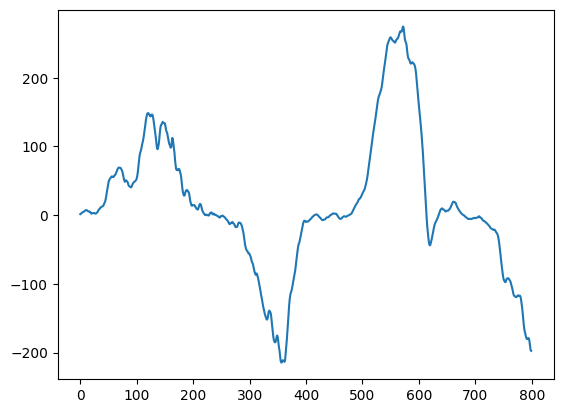

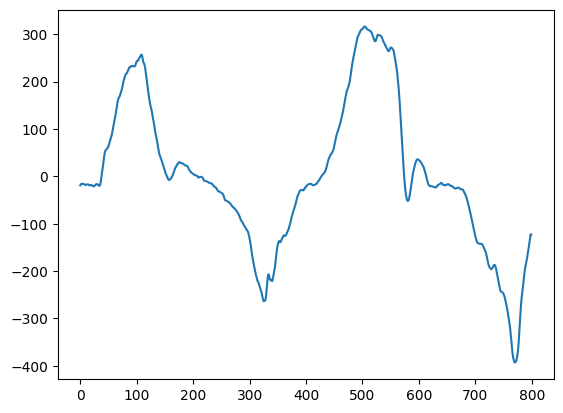

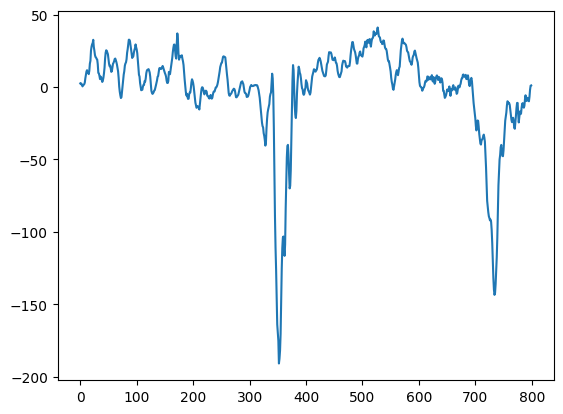

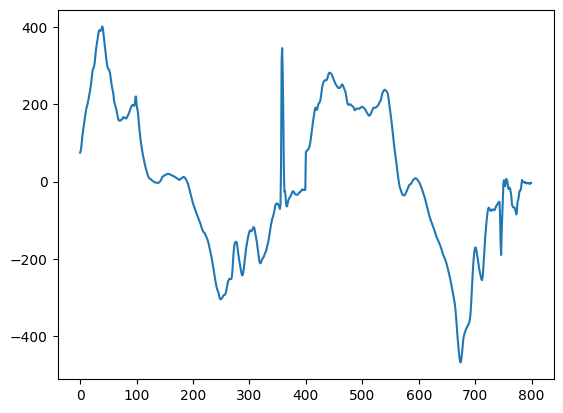

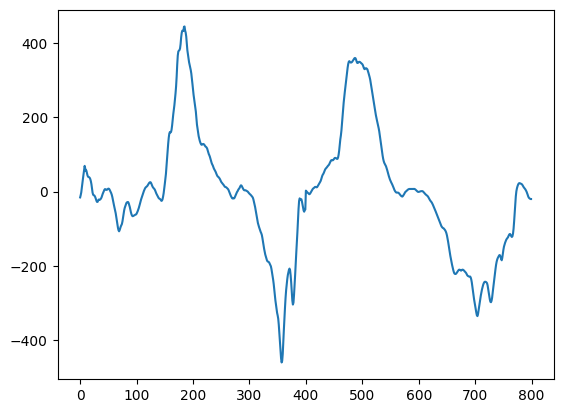

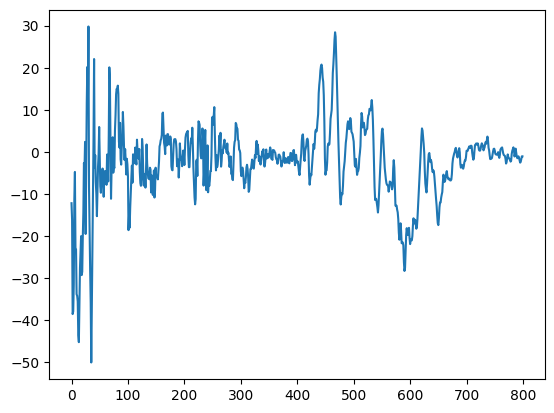

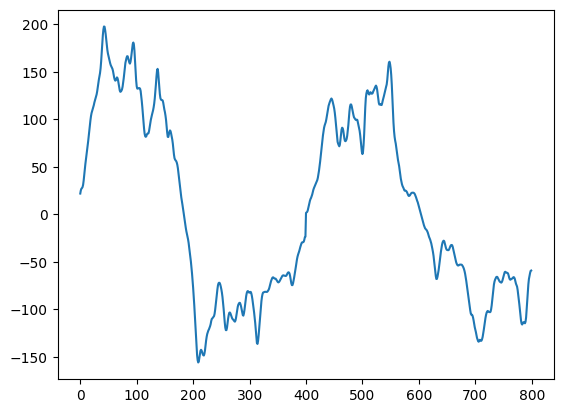

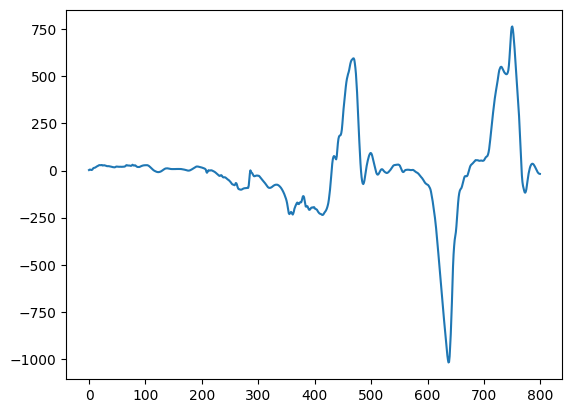

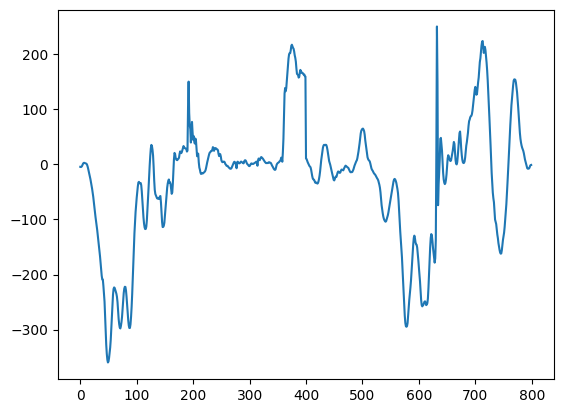

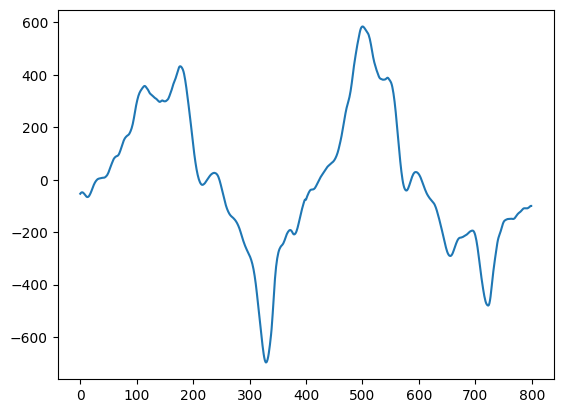

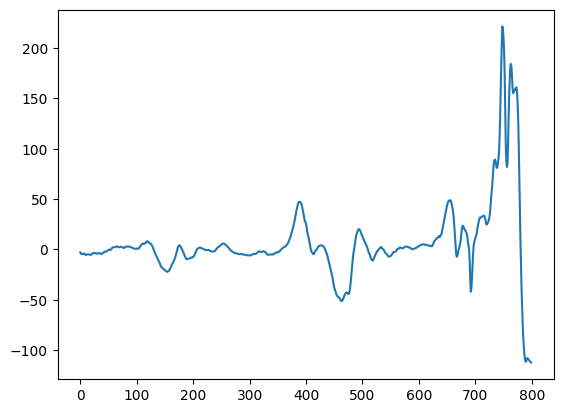

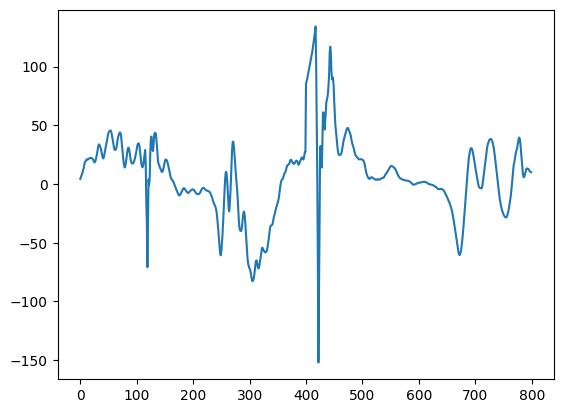

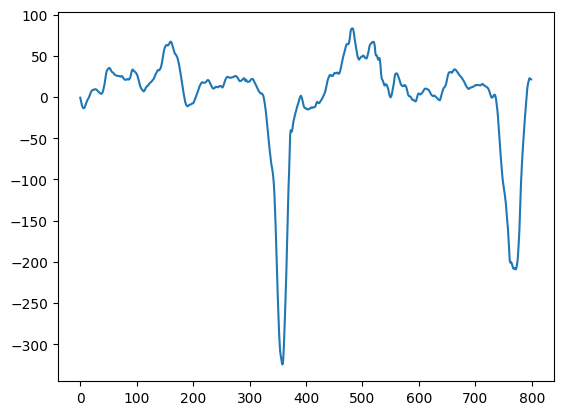

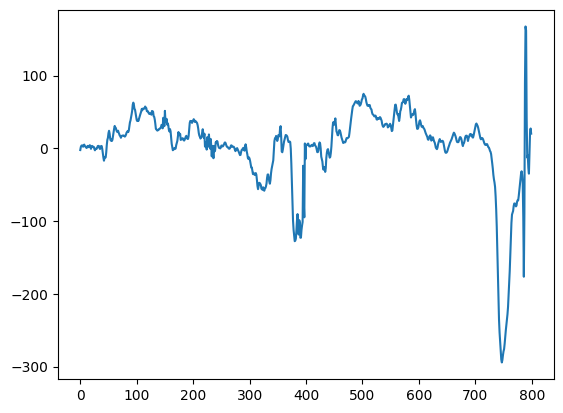

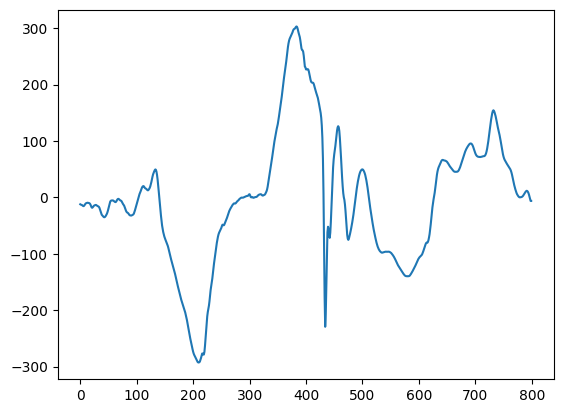

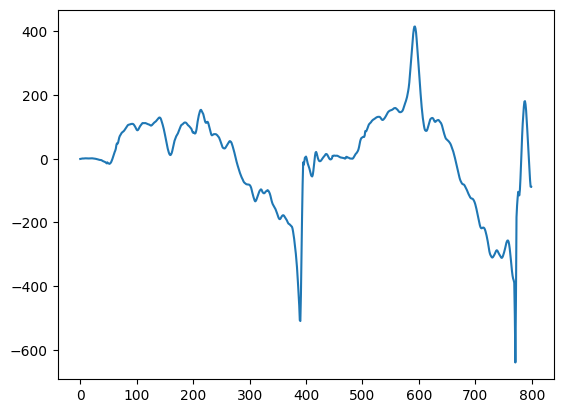

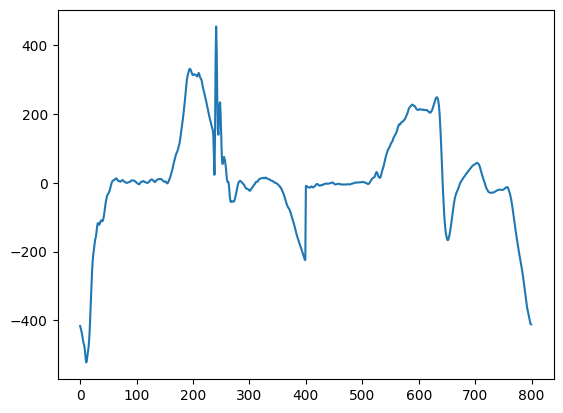

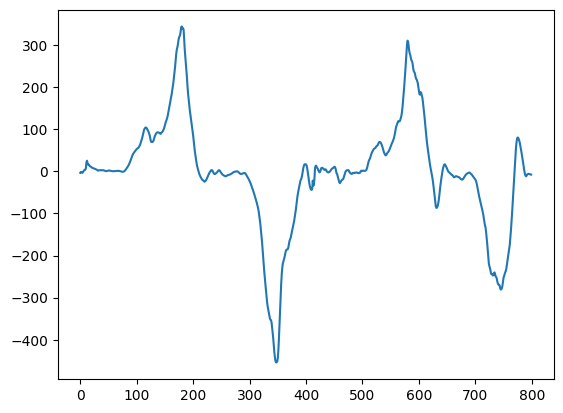

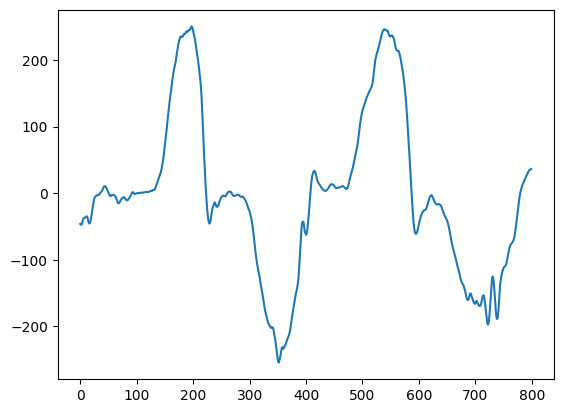

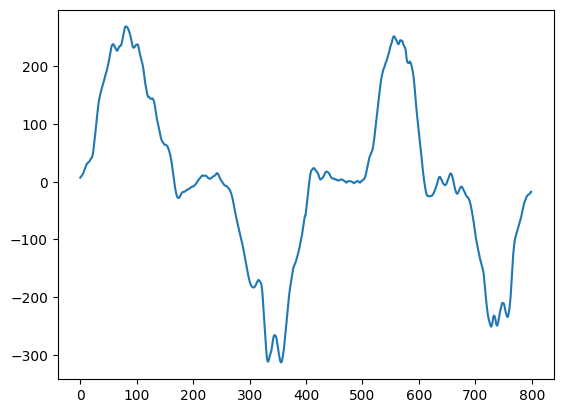

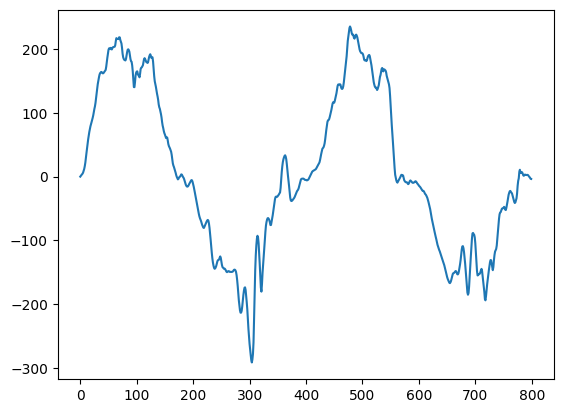

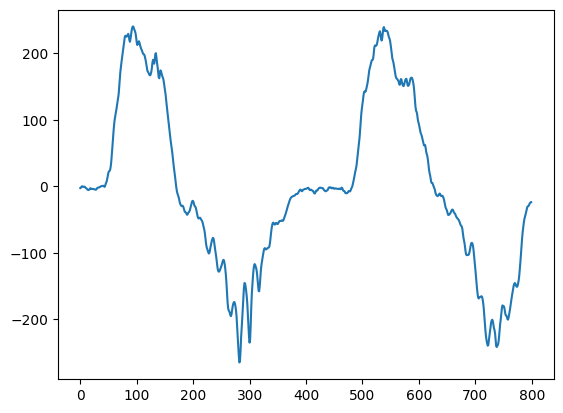

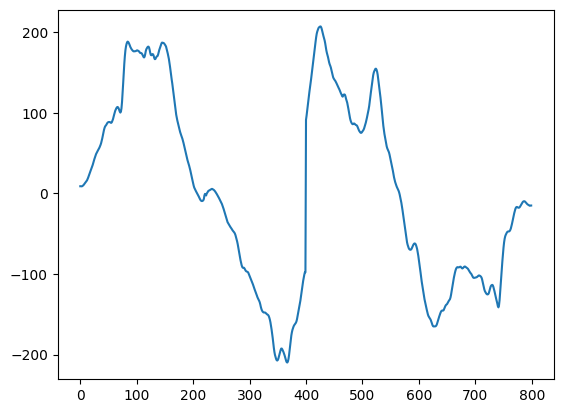

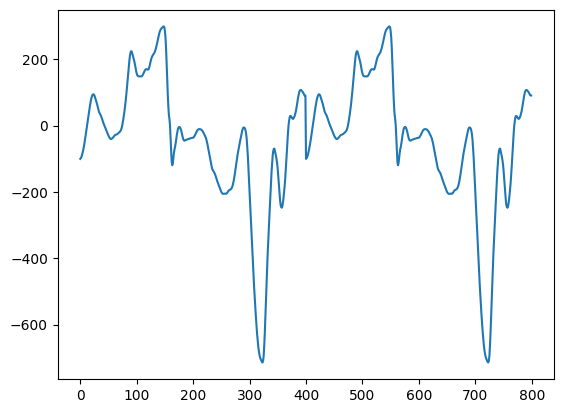

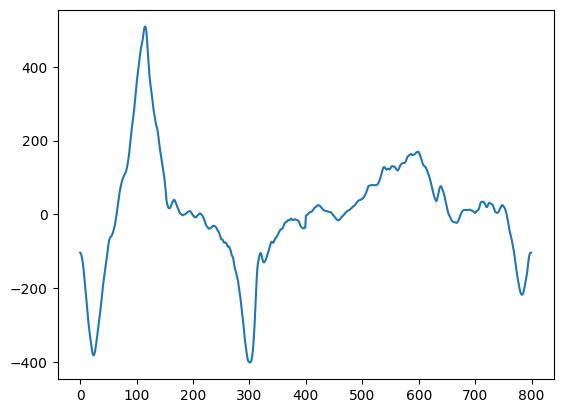

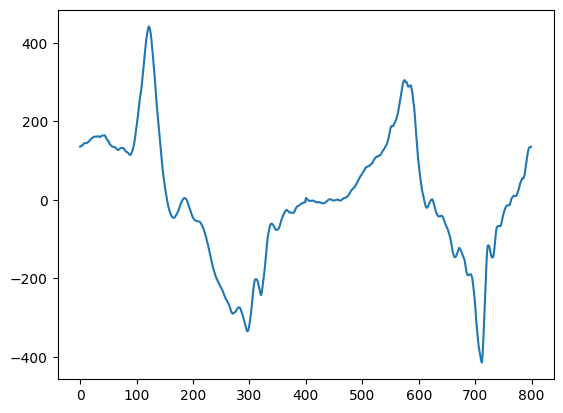

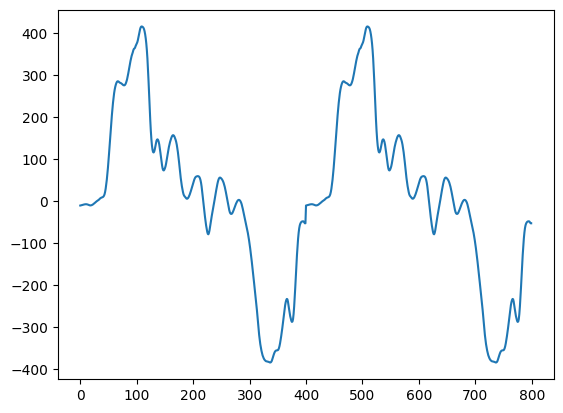

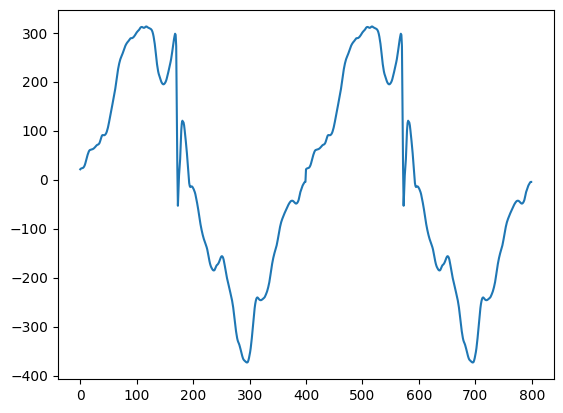

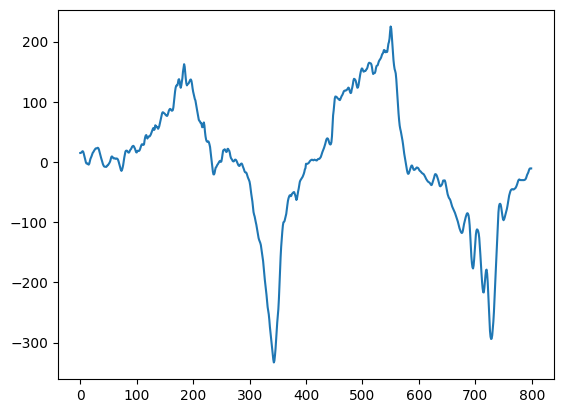

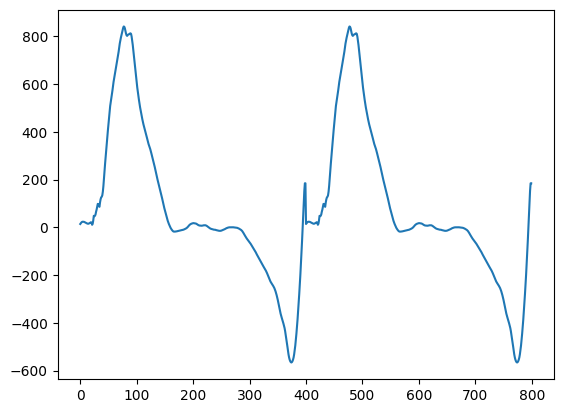

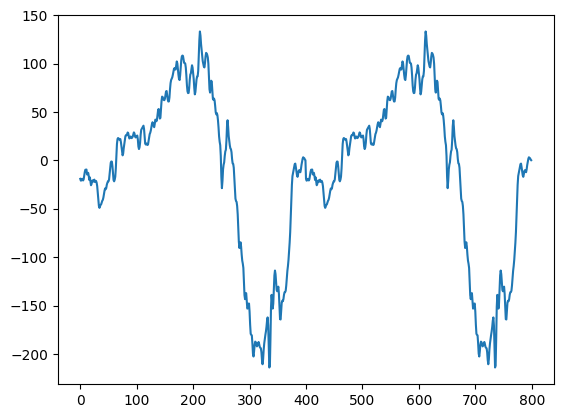

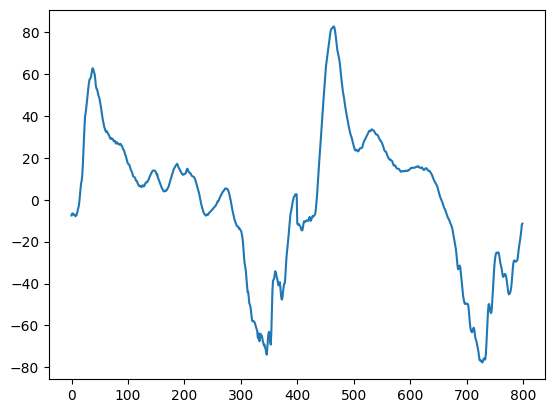

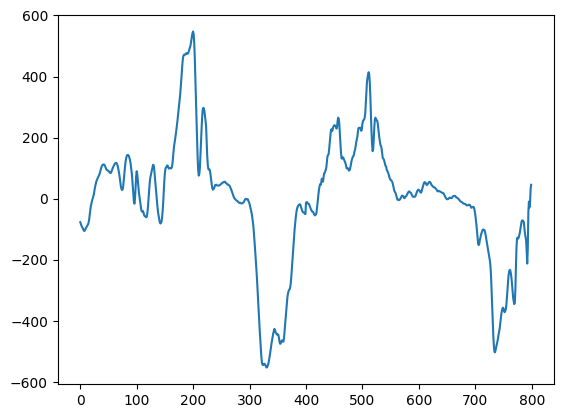

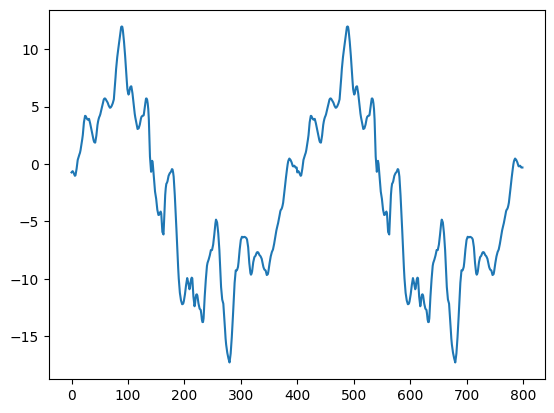

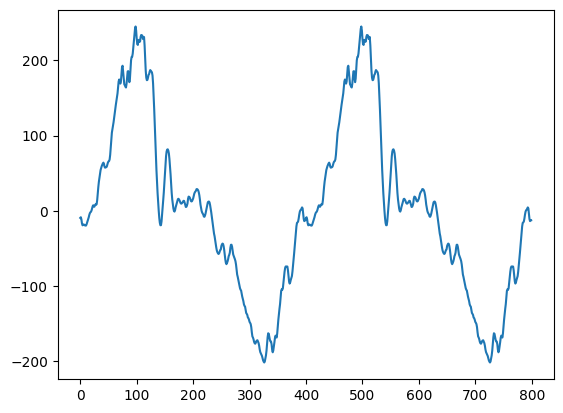

In [4]:
import matplotlib.pyplot as plt

newys = []
newpids = []
newvisits = []
newcohorts = []

for i in range(0, len(ys), 2):
    ysarray = np.array(ys)
    newys.append(np.concatenate((ysarray[i, :], ysarray[i+1, :])))
    newpids.append(pids[i])
    newvisits.append(visits[i])
    newcohorts.append(cohorts[i])

for i in range(len(newys)):
    plt.figure()
    plt.plot(newys[i])

In [5]:
# replacing old variables
ys = newys
pids = newpids
visits = newvisits
cohorts = newcohorts

len(ys), len(pids), len(visits), len(cohorts)

(35, 35, 35, 35)

## Merging with baseline data and Randomly taking one visit per PID

In [6]:
def random_sample(group):
    return group.sample(n=1)

In [7]:
df_processor = pd.DataFrame(ys)
df_processor['pids']=pids
df_processor['cohorts']=cohorts
df_processor['visits']=visits

baseline_df = pd.read_csv('/mnt/sdb/arafat/U-Extend/paper_data/final_clinical_df.csv')
baseline_df = baseline_df.drop(columns=['Dom','Gender'])

baseline_df['Normalized_Dynamometry (N/cm)'] = baseline_df['Avg. Dynamometry (N)'] / baseline_df['Forearm_Length (cm)']
baseline_df['Normalized Elbow Torque (Nm/cm)'] = baseline_df['Elbow Torque (Nm)'] / baseline_df['Forearm_Length (cm)']

df_processor['visits'] = pd.to_datetime(df_processor['visits'])
df_processor['visits'] = df_processor['visits'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_processor['visits'] = pd.to_datetime(df_processor['visits'], format = "%Y-%m-%d")

baseline_df['Sensor Data Date'] = pd.to_datetime(baseline_df['Sensor Data Date'], format = "%Y-%m-%d")
df_processor = pd.merge(df_processor, baseline_df, left_on=['pids','visits'], right_on=['PID','Sensor Data Date'], how='inner')

In [8]:
random_rows = df_processor.groupby(['pids']).apply(random_sample).reset_index(drop=True)
random_ys = random_rows.iloc[:,0:800].values
random_cohorts = random_rows['cohorts']

len(random_ys), len(random_cohorts)

(31, 31)

## Aligning Healthy and Patient Trajectories

In [9]:
# getting index of healthy and patient
idx_healthy = np.where(random_cohorts =='Healthy')
idx_not_healthy = np.where(random_cohorts !='Healthy')

In [10]:
time = np.array(range(800)).astype(float)
obj_all = fs.fdawarp(np.transpose(random_ys), time)

In [11]:
ys_healthy = random_ys[idx_healthy]
obj_healthy = fs.fdawarp(np.transpose(ys_healthy), time)
obj_healthy.srsf_align(parallel=True)

Initializing...
Compute Karcher Mean of 9 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


In [12]:
obj_dmdsma = fs.fdawarp(np.transpose(random_ys[idx_not_healthy]), time)
obj_dmdsma.srsf_align(parallel=True)

Initializing...
Compute Karcher Mean of 22 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


## Figure 3 

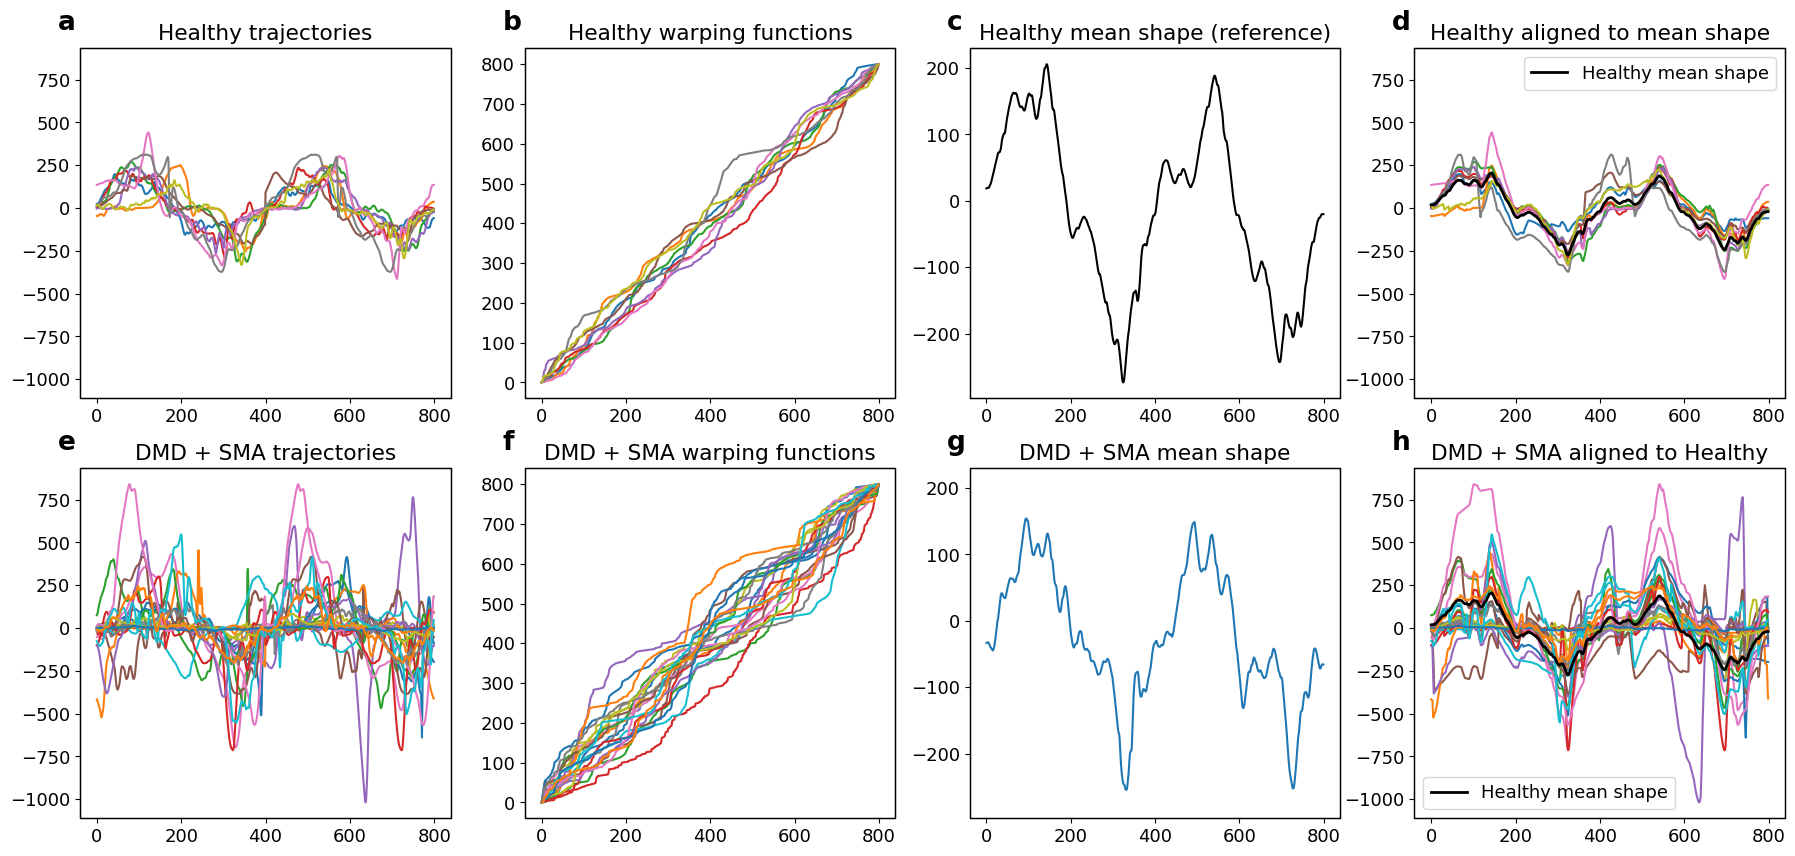

In [13]:
obj_all.multiple_align_functions(obj_healthy.fmean)

import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams.update({'font.size': 13})


colors = np.repeat(u'tab:red', random_ys.shape[0])
colors[idx_healthy]='green'

fig, axs = plt.subplots(2,4, figsize=(22, 10), facecolor='white', sharey='col')
labels = ['a', 'b', 'c','d','e','f','g','h']
k = 0 

for i in range(2):
     for j in range(4):
        ax = axs[i,j]
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')
        ax.set_facecolor('white')
        ax.patch.set_edgecolor('black')  
        ax.spines['bottom'].set_color('0')
        ax.spines['top'].set_color('0')
        ax.spines['left'].set_color('0')
        ax.spines['right'].set_color('0')
        ax.patch.set_linewidth(1)
        ax.text(-0.06, 1.11, labels[k], transform=axs[i, j].transAxes, fontsize=19, verticalalignment='top', fontweight='bold')
        k += 1 


for i in range(random_ys.shape[0]):    
    if i not in idx_healthy[0]:
        axs[1,0].plot(random_ys[i]) # raw dmd_sma
        axs[1,1].plot(obj_all.gam[:,i]*800) # dmd_
        axs[1,3].plot(obj_all.fn[:,i])
        

axs[0,0].set_title('Healthy trajectories')
axs[0,0].plot(obj_healthy.f)
axs[0,1].set_title('Healthy warping functions')
axs[0,1].plot(obj_healthy.gam*800)
axs[0,2].set_title('Healthy mean shape (reference)')
axs[0,2].plot(obj_healthy.fmean, color='black')

axs[0,3].plot(obj_healthy.fn)
axs[0,3].plot(obj_healthy.fmean, color='black',lw = 2, label='Healthy mean shape')
axs[0,3].legend(facecolor="white")
axs[1,3].plot(obj_healthy.fmean, color='black',lw = 2, label='Healthy mean shape')
axs[0,3].set_title('Healthy aligned to mean shape')


axs[1,0].set_title('DMD + SMA trajectories')
axs[1,1].set_title('DMD + SMA warping functions')
axs[1,3].set_title('DMD + SMA aligned to Healthy')


axs[1,2].set_title('DMD + SMA mean shape')
axs[1,2].plot(obj_dmdsma.fmean)
    
plt.legend(facecolor="white")
ax = plt.gca()
# plt.savefig('./pics/phase_amp_dom.png', dpi=300, bbox_inches='tight')

## Function for re-calculating PCA

In [14]:
import fdasrsf as fs
import fdasrsf.utility_functions as uf
import fdasrsf.geometry as geo
from scipy.linalg import norm, svd
from scipy.integrate import trapezoid, cumulative_trapezoid
from scipy.optimize import fminbound
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import fdasrsf.plot_style as plot


def recalc_pca(self, no=3, var_exp=None, id=None, stds=np.arange(-1, 2)):
        """
        This function calculates vertical functional principal component
        analysis on aligned data

        :param no: number of components to extract (default = 3)
        :param var_exp: compute no based on value percent variance explained
                        (example: 0.95)
        :param id: point to use for f(0) (default = midpoint)
        :param stds: number of standard deviations along geodesic to compute
                     (default = -1,0,1)
        :type no: int
        :type id: int

        :rtype: fdavpca object containing
        :return q_pca: srsf principal directions
        :return f_pca: functional principal directions
        :return latent: latent values
        :return coef: coefficients
        :return U: eigenvectors

        """
        fn = self.warp_data.fn
        time = self.warp_data.time
        qn = self.warp_data.qn

        M = time.shape[0]
        if var_exp is not None:
            if var_exp > 1:
                raise Exception("var_exp is greater than 1")
            no = M

        if id is None:
            mididx = int(np.round(M / 2))
        else:
            mididx = id

        Nstd = stds.shape[0]

        # FPCA
        mq_new = qn.mean(axis=1)
        N = mq_new.shape[0]
        m_new = np.sign(fn[mididx, :]) * np.sqrt(np.abs(fn[mididx, :]))
        #mqn = np.append(mq_new, m_new.mean())
        #self.mqn2 = mqn
        qn2 = np.vstack((qn, m_new))
        K = np.cov(qn2)

        U = self.U
        s = self.latent
        stdS = np.sqrt(s)

        # compute the PCA in the q domain
        q_pca = np.ndarray(shape=(N + 1, Nstd, no), dtype=float)
        for k in range(0, no):
            for l in range(0, Nstd):
                q_pca[:, l, k] = self.mqn2 + stds[l] * stdS[k] * U[:, k]

        # compute the correspondence in the f domain
        f_pca = np.ndarray(shape=(N, Nstd, no), dtype=float)
        for k in range(0, no):
            for l in range(0, Nstd):
                f_pca[:, l, k] = uf.cumtrapzmid(
                    time,
                    q_pca[0:N, l, k] * np.abs(q_pca[0:N, l, k]),
                    np.sign(q_pca[N, l, k]) * (q_pca[N, l, k] ** 2),
                    mididx,
                )
            fbar = fn.mean(axis=1)
            fsbar = f_pca[:, :, k].mean(axis=1)
            err = np.transpose(np.tile(fbar - fsbar, (Nstd, 1)))
            f_pca[:, :, k] += err

        N2 = qn.shape[1]
        c = np.zeros((N2, no))
        for k in range(0, no):
            for l in range(0, N2):
                c[l, k] = sum((np.append(qn[:, l], m_new[l]) - self.mqn2) * U[:, k])

        if var_exp is not None:
            cumm_coef = np.cumsum(s) / sum(s)
            no = int(np.argwhere(cumm_coef <= var_exp)[-1])

        self.q_pca = q_pca
        self.f_pca = f_pca
        self.latent = s[0:no]
        self.coef = c[:, 0:no]
        self.U = U[:, 0:no]
        self.id = mididx
        # self.mqn = mqn
        self.time = time
        self.stds = stds
        self.no = no

        return

In [15]:
from fdasrsf import fdavpca
fdavpca.recalc_pca = recalc_pca

## PCA for 100 trials

In [16]:
vpcas = []
random_rows_list = []

trials = 100

for trial in tqdm(range(trials)):

    # Then apply the function to each group defined by 'pid' and the sampled 'visit' to randomly sample based on 'trial'
    random_rows = df_processor.groupby(['pids']).apply(random_sample).reset_index(drop=True)
    ys = random_rows.iloc[:,0:800].values

    time = np.array(range(800)).astype(float)
    obj = fs.fdawarp(np.transpose(ys), time)

    obj.srsf_align(parallel=True)

    vpca = fdavpca(obj)
    vpca.calc_fpca(no=3)
    vpcas.append(vpca)
    random_rows_list.append(random_rows)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing...
Compute Karcher Mean of 31 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


## Fixing Sign Ambiguity

In [17]:
ref = 0

for trial in range(trials):
  for dim in range(vpcas[0].U.shape[1]):
    corr_pc = np.dot(vpcas[trial].U[:, dim], vpcas[ref].U[:, dim]) # pick eigenfunction
      
    if corr_pc < 0:
        vpcas[trial].U[:, dim] = -vpcas[trial].U[:, dim]
        vpcas[trial].coef[:, dim] = -vpcas[trial].coef[:, dim]

# recalculating
for i in range(trials):
    vpcas[i].recalc_pca()

## Figure 4

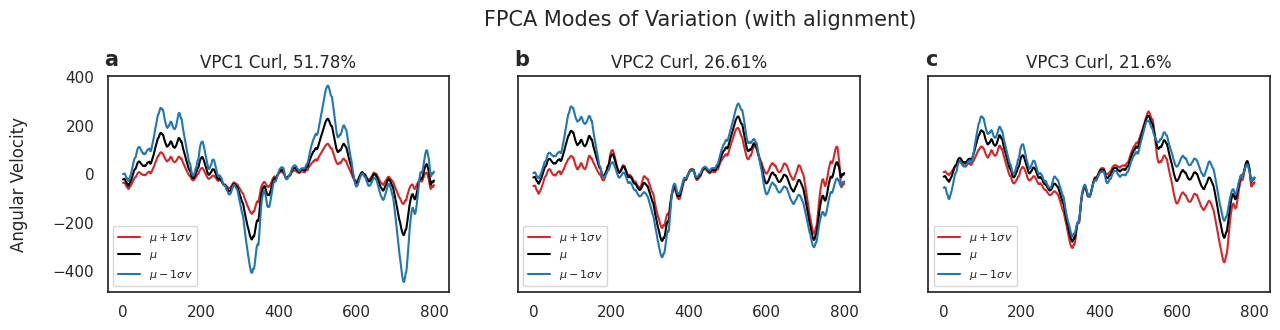

In [18]:
sns.set(font_scale=1)
for trial, vpca in enumerate(vpcas):
    
    labels = ['a', 'b', 'c']
    cumm_coef = 100 * (vpca.latent) / sum(vpca.latent)
    
    sns.set_style(style='white')
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    for i, ax in enumerate(axs):
        ax.plot(vpca.f_pca[:,2,i], label=r'$\mu + 1 \sigma v$', color='tab:red')
        ax.plot(vpca.f_pca[:,1,i], label=r'$\mu$', color='black')
        ax.plot(vpca.f_pca[:,0,i], label=r'$\mu - 1 \sigma v$', color='tab:blue')
        ax.set_title("VPC{} Curl, {}%".format(i+1, round(cumm_coef[i], 2)), fontsize=12)
        ax.legend(loc='lower left', fontsize=8)
        ax.text(-0.01, 1.12, labels[i], transform=ax.transAxes, fontsize=15, 
                verticalalignment='top', fontweight='bold')
    
    plt.subplots_adjust(top=0.83)
    fig.suptitle('FPCA Modes of Variation (with alignment)', fontsize=15, y=1.05, x=0.52)
    fig.text(0.06, 0.47, 'Angular Velocity', va='center', rotation='vertical', fontsize=12)
    #plt.savefig('figure_multi_pca/twin_eigenfunctionscurl{}.png'.format(trial), dpi=300, bbox_inches='tight')

## Function for taking mean of multiple dataframe

In [19]:
def mean_df_calc(df_list):
    # Separate numeric and non-numeric data
    numeric_dfs = [df.select_dtypes(include='number') for df in df_list]
    non_numeric_df = df_list[0].select_dtypes(exclude='number')
    
    # Calculate the mean of numeric data
    numeric_mean_df = sum(numeric_dfs) / len(numeric_dfs)
    
    # Combine numeric mean with non-numeric data from the first DataFrame
    mean_df = numeric_mean_df.join(non_numeric_df)
    return mean_df

In [20]:
df_list = []

for trial, vpca in enumerate(vpcas):
    vpca_df = pd.DataFrame(vpca.coef, columns=['vpc1', 'vpc2', 'vpc3'])
    df_pca_analyze = pd.concat([random_rows_list[trial].iloc[:,800:,].reset_index(drop=True), vpca_df], axis=1)
    df_list.append(df_pca_analyze)

mean_df = mean_df_calc(df_list)

## Loading saved vpc curl and vpc knock

In [21]:
df_curl = pd.read_csv('vpc_curl.csv')
df_knock = pd.read_csv('vpc_knock.csv')

X_df = pd.merge(df_curl, df_knock, left_on=['PID'], right_on=['PID'], how='inner',suffixes=('_curl', '_knock'))
X_df

,pids_curl,PID,Visit #_curl,Age_curl,Forearm_Length (cm)_curl,CSA (cm^2)_curl,Normalized_CSA (cm^2/cm)_curl,Avg_Long_Echo_curl,Avg_Trans_Echo_curl,Avg_Echo_curl,...,Normalized_Dynamometry (N/cm)_knock,vpc1_knock,vpc2_knock,vpc3_knock,visits_knock,Sensor Data Date_knock,Cohort_knock,DTW_knock,LCSS_knock,DEXA Date_knock
0,1.0,1.0,1.54,10.0,19.540,3.315800,0.218206,52.0146,57.90420,54.95940,...,0.739481,-14.005069,6.536640,4.860552,2021-03-26,2021-03-26,DMD,0.105,0.985,NaN
1,2.0,2.0,1.00,12.0,24.000,7.590000,0.316250,53.4000,41.45000,47.42500,...,0.295930,21.146474,11.440316,20.812938,2021-02-11,2021-02-11,DMD,0.1708,0.972,NaN
2,3.0,3.0,1.44,15.0,22.720,1.962800,0.086432,37.7864,46.98880,42.38760,...,0.623269,-7.002437,-12.439710,3.499236,2021-07-20,2021-07-20,SMA,0.1415,0.9762,NaN
3,5.0,5.0,1.00,28.0,24.000,8.150000,0.339583,33.2000,38.23000,35.71500,...,NaN,-16.298848,0.934483,4.723615,2021-03-11,2021-03-11,DMD,0.2767,0.972,NaN
4,8.0,8.0,1.00,6.0,21.000,7.010000,0.333810,40.9800,36.96000,38.97000,...,1.394623,3.909516,2.004859,0.054437,2021-04-21,2021-04-21,Healthy,0.1114,1,NaN
5,10.0,10.0,1.00,2.0,14.000,2.060000,0.147143,35.0300,33.51000,34.27000,...,NaN,-30.536468,0.683415,5.390314,2021-03-24,2021-03-24,SMA,0.3067,0.897,NaN
6,11.0,11.0,1.46,6.0,18.000,2.428600,0.134922,36.8764,35.19140,36.03390,...,NaN,-11.653281,-2.799379,-5.362087,2021-03-24,2021-03-24,DMD,0.2697,0.934,NaN
7,12.0,12.0,1.57,33.0,22.355,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.364637,1.271983,-5.237292,2021-10-15,2021-10-15,DMD,0.2184,0.9423,NaN
8,14.0,14.0,1.00,15.0,23.000,2.401287,0.104404,44.2000,50.90574,47.55287,...,0.878040,-2.790194,-0.157573,-3.683915,2021-04-28,2021-04-28,DMD,0.1553,0.967,2021-04-28
9,15.0,15.0,1.00,7.0,19.000,3.120000,0.164211,51.6500,44.57000,48.11000,...,0.333851,-8.290478,1.902755,5.067496,2021-05-13,2021-05-13,SMA,0.2123,0.955,NaN


## Renaming

In [22]:
df_final_box = pd.DataFrame()
df_final_box['Cohort'] = X_df['Cohort_curl']
df_final_box['Age'] = X_df['Age_curl']
df_final_box['Brooke'] = X_df['Brooke_curl']
df_final_box['Avg_Echo (gsv)'] = X_df['Avg_Echo_curl']
df_final_box['NET (Nm/cm)'] = X_df['Normalized Elbow Torque (Nm/cm)_curl']

df_final_box['VPC1 Curl'] = X_df['vpc1_curl']
df_final_box['VPC2 Curl'] = X_df['vpc2_curl']

df_final_box['VPC1 Knock'] = X_df['vpc1_knock']
df_final_box['VPC2 Knock'] = X_df['vpc2_knock']

## Figure 6

Text(0.5, 0.98, 'Boxplot of Clinical and Wearable Features')

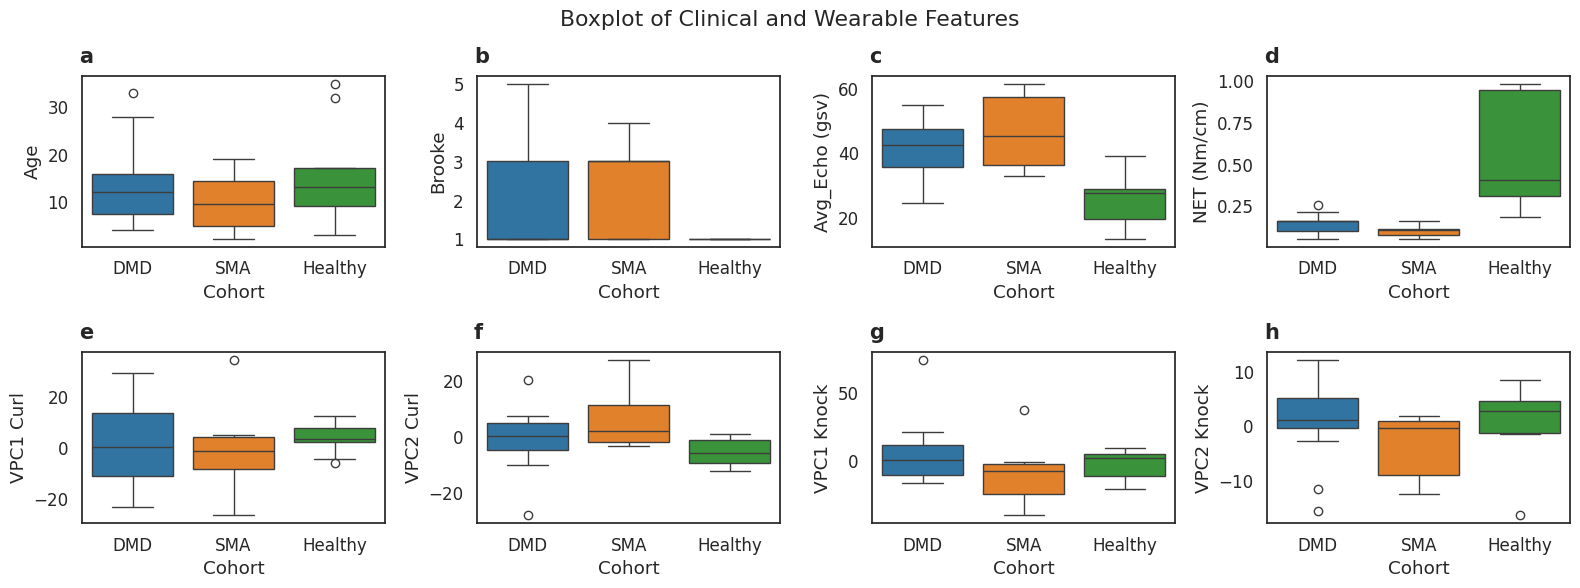

In [23]:
import seaborn as sns
from statannot import add_stat_annotation

feat_columns = ['Age','Brooke','Avg_Echo (gsv)','NET (Nm/cm)','VPC1 Curl','VPC2 Curl','VPC1 Knock','VPC2 Knock']

sns.set(font_scale=1.1)
sns.set_style(style='white')

my_pal = {"DMD": "tab:blue", "SMA": "tab:orange", "Healthy":"tab:green"}


fig, axs = plt.subplots(2, 4, figsize=(4*4, 6))
labels = ['a','b','c','d','e','f','g','h']

for i, feat_col in enumerate(feat_columns):

    a = sns.boxplot(data=df_final_box, x='Cohort', y=feat_col, ax=axs[int(i/4), i%4], palette=my_pal)

    # add_stat_annotation(a, data=df_final_box, x='Cohort', y=feat_col, 
    #                     box_pairs=[("DMD", "Healthy"), ("DMD", "SMA"), ("SMA", "Healthy")],
    #                     test='t-test_ind', text_format='simple')
    #axs[i].set_title(titles[i])
    axs[int(i/4), i%4].text(-0.01, 1.17, labels[i], transform=axs[int(i/4), i%4].transAxes, fontsize=15, 
                verticalalignment='top', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.suptitle('Boxplot of Clinical and Wearable Features')
# plt.savefig('pics/box_plots.png',bbox_inches='tight',dpi=300)

## Figure 7

Text(0.5, 1.0, 'VPC1 Curl Cohort Correlations')

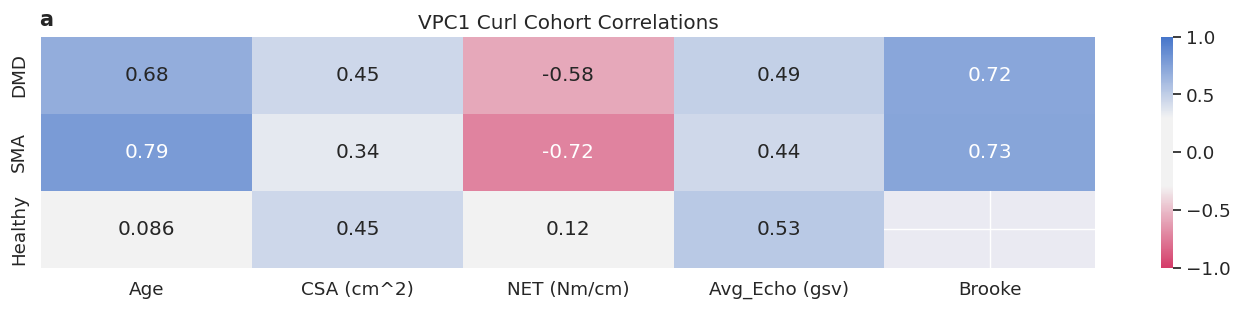

In [24]:
from collections import defaultdict
import seaborn as sb

corr_vpcdict = defaultdict(list)

feat_columns = ['PID','Age','CSA (cm^2)','Normalized Elbow Torque (Nm/cm)','Avg_Echo','Brooke',
                'vpc1','vpc2','vpc3']
    

for trial, vpca in enumerate(vpcas):
    vpca_df = pd.DataFrame(vpca.coef, columns=['vpc1', 'vpc2', 'vpc3'])
    df_pca_analyze = pd.concat([random_rows_list[trial].iloc[:,800:,].reset_index(drop=True), vpca_df], axis=1)
    df = df_pca_analyze
        
    clist = ['DMD','SMA','Healthy']
        
    
    vpcs = ['vpc1', 'vpc2']
        
    for vpc in vpcs:
        corrs = []
        for c in clist: 
            df_b = df[df['cohorts'] == c]
            corr = df_b[feat_columns].corr().loc[vpc].iloc[1:-3]
            
            corrs.append(corr)
                
            
        df_corr = pd.concat(corrs, axis=1)
        df_corr.columns = ['DMD','SMA','Healthy']
            
        df_corr = df_corr.transpose()
        df_corr = df_corr.rename(columns={'Normalized Elbow Torque (Nm/cm)': 'NET (Nm/cm)',
                                              'Avg_Echo':'Avg_Echo (gsv)'})
        corr_vpcdict[vpc].append(df_corr)
        

sns.set(font_scale=1.2)
plt.figure(figsize = (17,3))

labels = ['a']

mean_corr = mean_df_calc(corr_vpcdict['vpc1'])
sb.heatmap(mean_corr, cmap=sb.diverging_palette(0, 255, sep=77, as_cmap=True), 
                              annot=True, vmin=-1, vmax=1, xticklabels = True)

plt.text(-0.01, -0.35, labels[0], fontsize=15, verticalalignment='top', fontweight='bold')

plt.title('VPC1 Curl Cohort Correlations')
# plt.savefig('pics/twinvpc1_curl4.png', dpi=300, bbox_inches='tight')

## PLS canonical

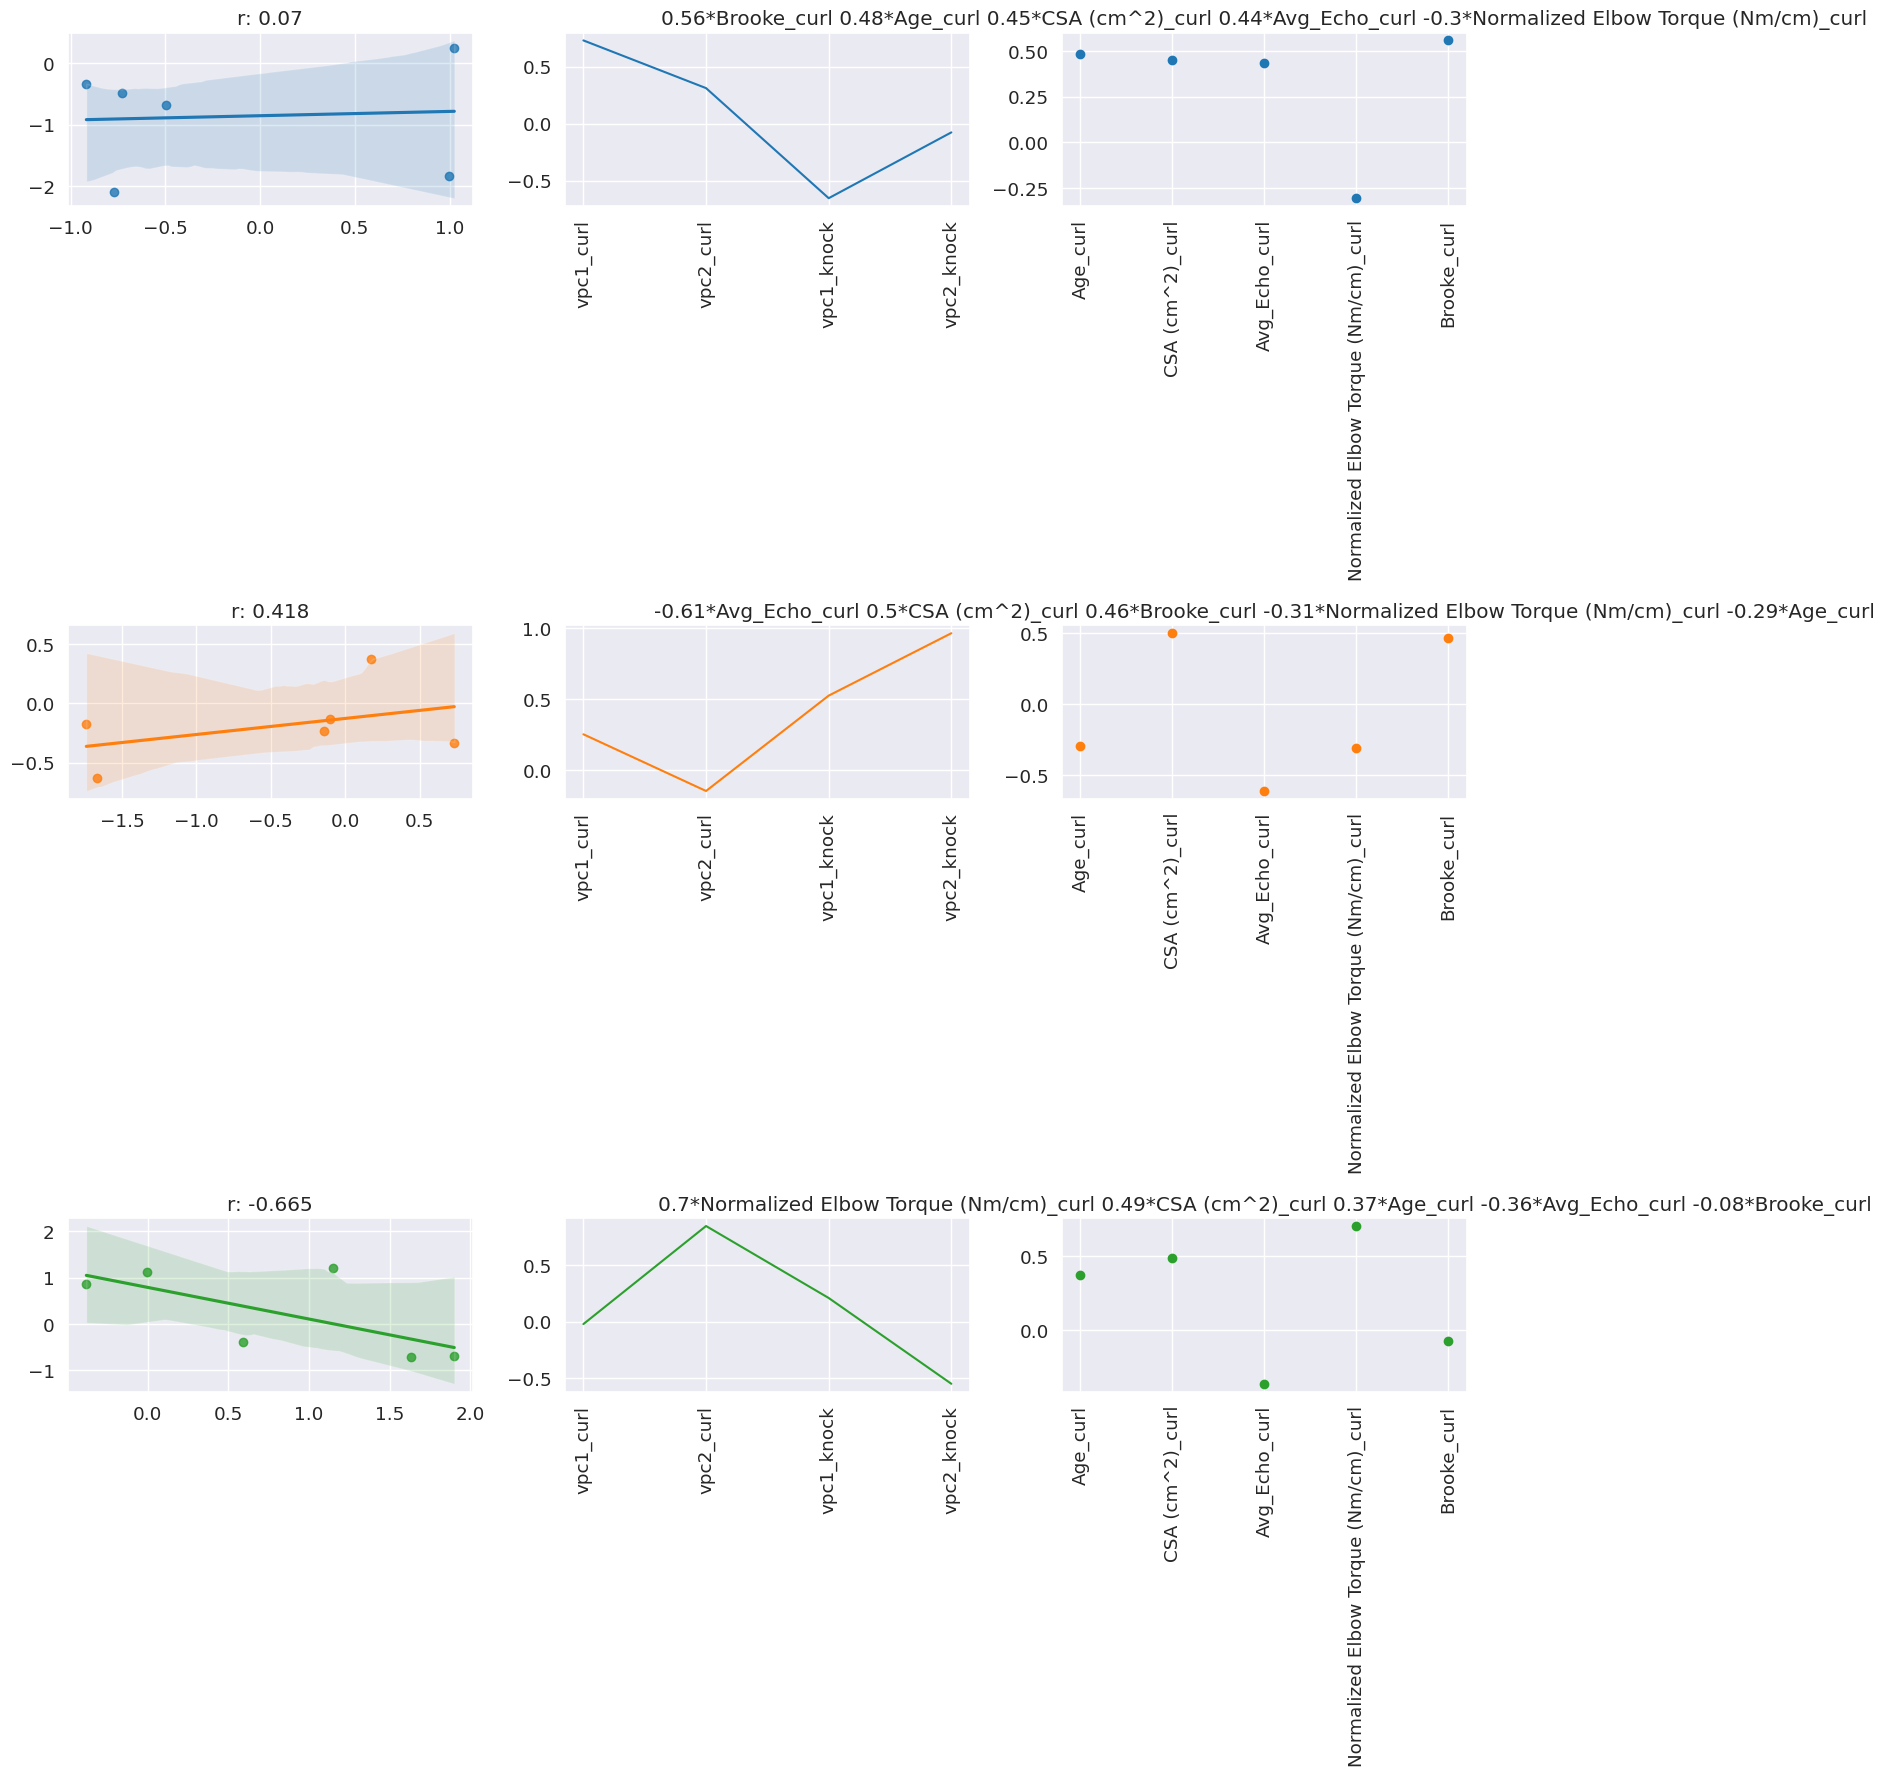

In [25]:
df_curl = pd.read_csv('vpc_curl.csv')
df_knock = pd.read_csv('vpc_knock.csv')

X_df = pd.merge(df_curl, df_knock, left_on=['PID'], right_on=['PID'], how='inner',suffixes=('_curl', '_knock'))
X_df = X_df[(X_df['Cohort_curl'] == 'DMD') | (X_df['Cohort_curl'] == 'SMA')]

X_df = X_df.select_dtypes(include='number')
X_df = X_df.fillna(X_df.median())

# from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSCanonical

# X_cols = ['vpc1_curl','vpc2_curl','vpc3_curl','vpc1_knock','vpc2_knock','vpc3_knock']

X_cols = ['vpc1_curl','vpc2_curl','vpc1_knock','vpc2_knock']
Y_cols = ['Age_curl','CSA (cm^2)_curl', 'Avg_Echo_curl','Normalized Elbow Torque (Nm/cm)_curl','Brooke_curl',]

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_df, test_size=0.3, shuffle=True)


x_tr = X_train[X_cols]
y_tr = X_train[Y_cols]

x_tst = X_test[X_cols]
y_tst = X_test[Y_cols]

#X = X + 1000*np.random.normal(size=X.shape)
# y_tr.columns

# from sklearn.cross_decomposition import CCA
# #X = [[0., 0., 1.], [1.,0.,0.], [2.,2M.,2.], [3.,5.,4.]]
# #>>> Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
# cca = CCA(n_components=1)
# cca.fit(X, Y)
# #CCA(n_components=1)
# #>>> X_c, Y_c = cca.transform(X, Y)

rank = 3
plsca = PLSCanonical(n_components=rank)
# plsca = CCA(n_components=rank)
plsca.fit(x_tr, y_tr)
X_train_r, Y_train_r = plsca.transform(x_tr, y_tr)
X_test_r, Y_test_r = plsca.transform(x_tst, y_tst)

fig, axs = plt.subplots(rank, 3, figsize=(5*rank, 6*3))

colors = ['tab:blue', 'tab:orange', 'tab:green']

corrs = []

for r in range(rank):
    
    x = X_test_r[:,r]
    y = Y_test_r[:,r]
    
    rho = round(np.corrcoef(x, y)[0,1], 3)
    
    corrs.append(rho)

    axs[r,0].set_title("r: {}".format(rho))
    #axs[r,0].scatter(x, y)
    
    sns.regplot(x=x, y=y, ax=axs[r,0], color=colors[r])
    
    idxs = np.argsort(np.abs(plsca.y_loadings_[:,r]))[-5:][::-1]
    titles = y_tst.columns[idxs]
    coefs = plsca.y_loadings_[:,r][idxs]

    plot_title = ' '.join([str(round(c, 2))+'*'+str(t) for c, t in zip(coefs, titles)])
    
    
    #axs[r,1].set_title('physiology pattern: {}'.format(r))
    axs[r,1].plot(plsca.x_loadings_[:,r], c=colors[r])
    
    axs[r,2].scatter(range(y_tr.shape[1]),plsca.y_loadings_[:,r], c=colors[r])
    axs[r, 2].set_title(plot_title)
    
    axs[r,1].set_xticks(range(x_tr.shape[1]))
    axs[r,1].set_xticklabels(x_tr.columns, rotation=90)
    axs[r,2].set_xticks(range(y_tr.shape[1])) 
    axs[r,2].set_xticklabels(y_tr.columns, rotation=90)

    
plt.tight_layout()
#plt.savefig('CCA_rank_{}.png'.format(r), dpi=300, bbox_inches='tight')

## Storing Corrs and PLS list

In [26]:
from scipy import stats
from sklearn.cross_decomposition import PLSCanonical

pls_list = []
trials = 10000
corrs = np.zeros((trials, rank))


for i in tqdm(range(trials)):

    X_train, X_test = train_test_split(X_df, test_size=0.3, shuffle=True)

    x_tr = X_train[X_cols]
    y_tr = X_train[Y_cols]

    x_tst = X_test[X_cols]
    y_tst = X_test[Y_cols]


    #rank = 3

    # plsca = CCA(n_components=rank)
    plsca = PLSCanonical(n_components=rank)
    plsca.fit(x_tr, y_tr)
    pls_list.append(plsca)
    
    X_train_r, Y_train_r = plsca.transform(x_tr, y_tr)
    X_test_r, Y_test_r = plsca.transform(x_tst, y_tst)

    for r in range(rank):

        x = X_test_r[:,r]
        y = Y_test_r[:,r]
        
        rho, _ = stats.pearsonr(x, y)
        rho = round(rho, 3)
        
        corrs[i,r] = rho

  0%|          | 0/10000 [00:00<?, ?it/s]

## Using corrs (trial x rank), pls_list (trial) to generate necessary variables

In [27]:
rho_df = pd.DataFrame(corrs.flatten(), columns=['rho'])
rho_df['rank'] = list(range(rank))*trials

X_weights = []
Y_weights = []

for i, plsca in enumerate(pls_list):
    for r in range(rank):

        r1 = list(plsca.x_loadings_[:,r])
        r1.append(r)
        
        r2 = list(plsca.y_loadings_[:,r])
        r2.append(r)

        X_weights.append(r1)
        Y_weights.append(r2)
        
xweights_df = pd.DataFrame(X_weights)
yweights_df = pd.DataFrame(Y_weights)

xweights_df.columns = [*X_cols,'rank']
yweights_df.columns = [*Y_cols,'rank']

cca_df = pd.concat([rho_df, xweights_df.drop('rank',axis=1), yweights_df.drop('rank',axis=1)],axis=1)
cca_df.groupby('rank').agg('median')


cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC1 Knock','VPC2 Knock','Age',
                  'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

## Bootstrapped CCA coefficient distribution plot

[0.248 0.777 0.945]
[-0.665 -0.06   0.546]
[-0.574  0.139  0.712]


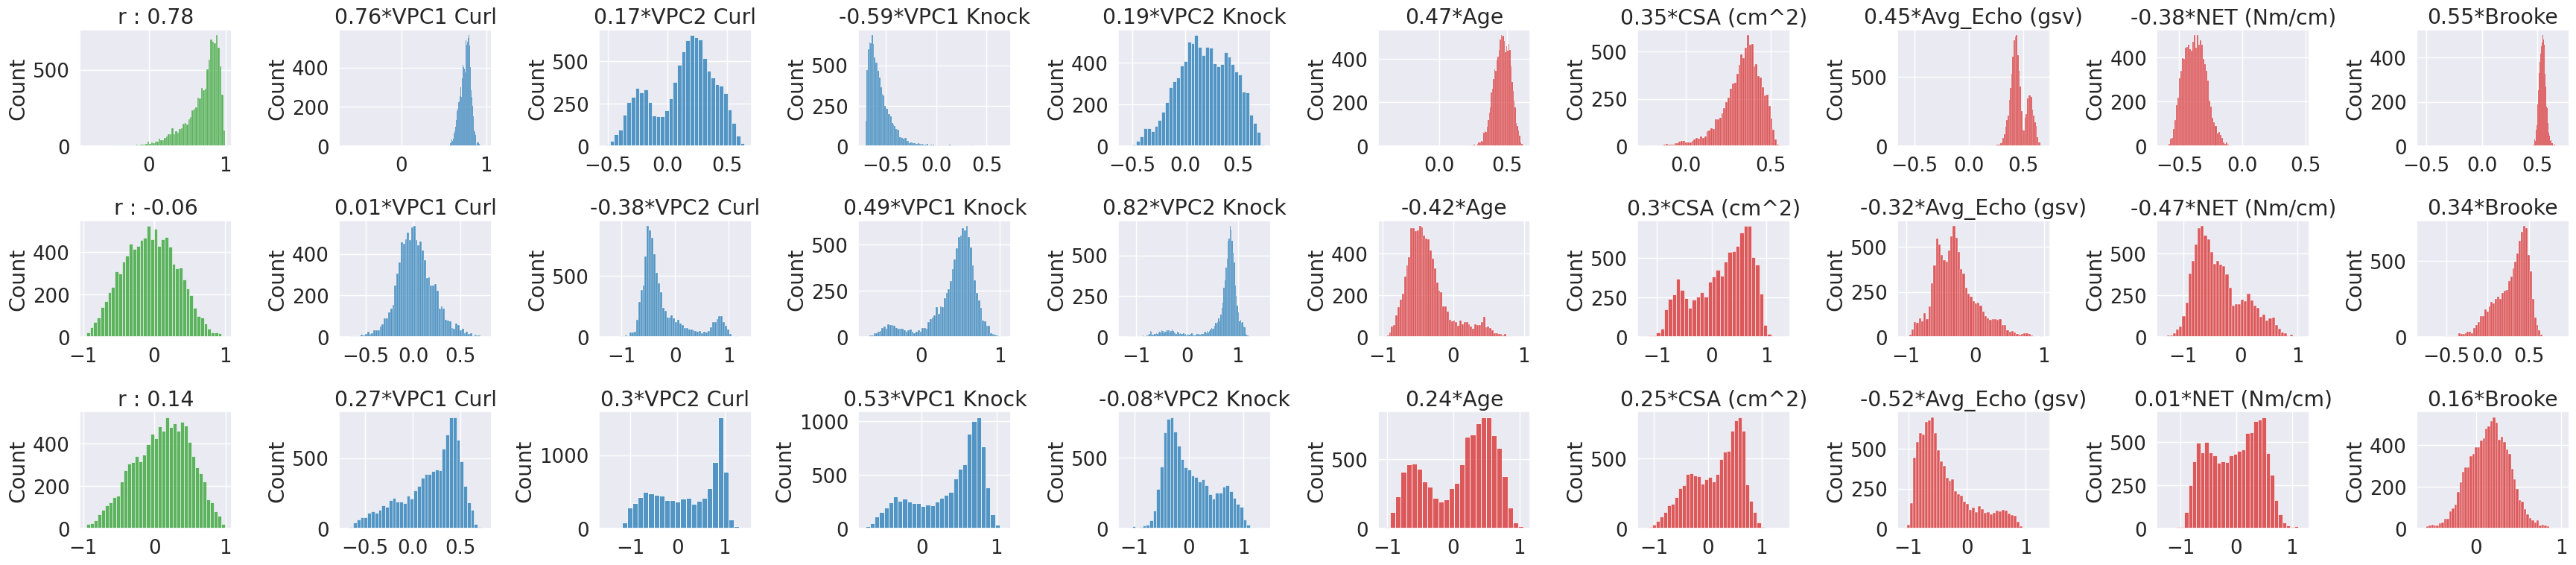

In [28]:
import seaborn as sns
sns.set(font_scale=1.7)
fig, axs = plt.subplots(3, 10, figsize=(35, 8))

for i, cca_r in cca_df.groupby('rank'):
    df = (cca_r.drop('rank', axis=1))
    
    for j, c in enumerate(df.columns):
        if c in cca_df.columns[2:6]:
            col = 'tab:blue'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        elif c in cca_df.columns[6:]:
            col = 'tab:red'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        else:
            col = 'tab:green'
            axs[i,j].set_title('{} : {}'.format(c, round( df[c].median(), 2)))
        hist = sns.histplot(data=df, x=c, ax=axs[i,j], color=col)
        hist.set(xlabel=None)
        #axs[i,j].axis('off')
        
        
plt.tight_layout()
#plt.savefig('./pics/cca_final.png', bbox_inches='tight')

for i, cca_r in cca_df.groupby('rank'):
    df = cca_r['r']
    #t_stat, p_value_overall = stats.ttest_1samp(df.values, 0)
    print(np.percentile(df, [5, 50, 95]))

## Fixing Sign

In [29]:
import numpy as np

# Reference index
ref = 0

# Reference weights
X_ref_weights = pls_list[0].x_weights_
Y_ref_weights = pls_list[0].y_weights_

for trial in range(1, len(pls_list)):  # Assuming pls_list is a list of PLSCanonical objects
    for dim in range(pls_list[0].x_weights_.shape[1]):
        # Correlation for X weights
        corr_x = np.dot(pls_list[trial].x_weights_[:, dim], X_ref_weights[:, dim])
        
        # Correlation for Y weights
        corr_y = np.dot(pls_list[trial].y_weights_[:, dim], Y_ref_weights[:, dim])
        
        if corr_x < 0:
            pls_list[trial].x_weights_[:, dim] = -pls_list[trial].x_weights_[:, dim]
            pls_list[trial].x_loadings_[:, dim] = -pls_list[trial].x_loadings_[:, dim]
            corrs[trial, dim] = -corrs[trial,dim]

        if corr_y < 0:
            pls_list[trial].y_weights_[:, dim] = -pls_list[trial].y_weights_[:, dim]
            pls_list[trial].y_loadings_[:, dim] = -pls_list[trial].y_loadings_[:, dim]
            corrs[trial, dim] = -corrs[trial,dim]


# storing in dataframe
rho_df = pd.DataFrame(corrs.flatten(), columns=['rho'])
rho_df['rank'] = list(range(rank))*trials

X_weights = []
Y_weights = []

for i, plsca in enumerate(pls_list):
    for r in range(rank):

        r1 = list(plsca.x_loadings_[:,r])
        r1.append(r)
        
        r2 = list(plsca.y_loadings_[:,r])
        r2.append(r)

        X_weights.append(r1)
        Y_weights.append(r2)
        
xweights_df = pd.DataFrame(X_weights)
yweights_df = pd.DataFrame(Y_weights)

xweights_df.columns = [*X_cols,'rank']
yweights_df.columns = [*Y_cols,'rank']

cca_df = pd.concat([rho_df, xweights_df.drop('rank',axis=1), yweights_df.drop('rank',axis=1)],axis=1)
cca_df.groupby('rank').agg('median')

cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC1 Knock','VPC2 Knock','Age',
                  'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

# cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC3 Curl','VPC1 Knock','VPC2 Knock','VPC3 Knock','Age',
#                   'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

## Figure 8

[0.248 0.777 0.945]
[-0.616 -0.008  0.621]
[-0.607  0.131  0.698]


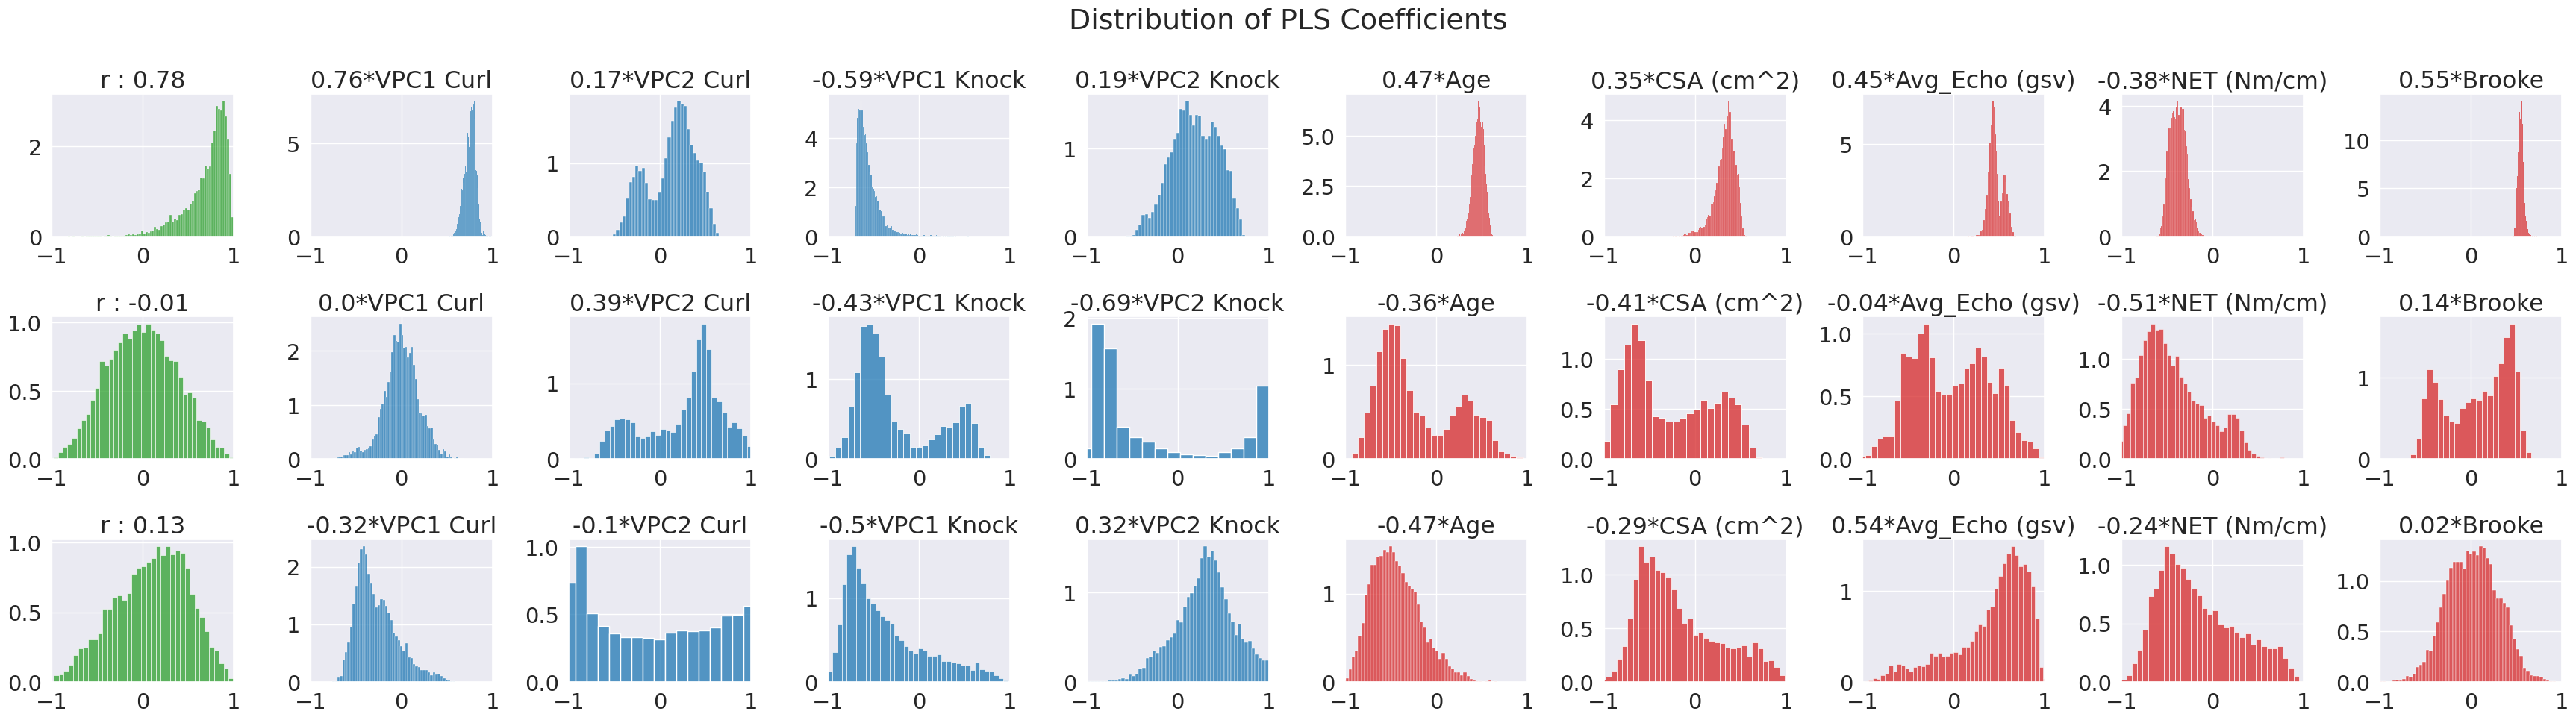

In [30]:
import seaborn as sns
sns.set(font_scale=1.9)
# Update the global font size
# plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(3, 10, figsize=(35, 10))

for i, cca_r in cca_df.groupby('rank'):
    df = (cca_r.drop('rank', axis=1))
    
    for j, c in enumerate(df.columns):
        axs[i,j].set_xlim([-1, 1])
        if c in cca_df.columns[2:6]:
            col = 'tab:blue'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        elif c in cca_df.columns[6:]:
            col = 'tab:red'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        else:
            col = 'tab:green'
            axs[i,j].set_title('{} : {}'.format(c, round( df[c].median(), 2)))
        hist = sns.histplot(data=df, x=c, ax=axs[i,j], color=col, stat='density')
        hist.set(xlabel=None,ylabel=None)
        #axs[i,j].axis('off')
        
        
plt.suptitle('Distribution of PLS Coefficients')
plt.tight_layout()
# plt.savefig('./pics/cca_final.png', bbox_inches='tight')

for i, cca_r in cca_df.groupby('rank'):
    df = cca_r['r']
    print(np.percentile(df, [5, 50, 95]))

## Figure 10

<Figure size 1200x600 with 0 Axes>

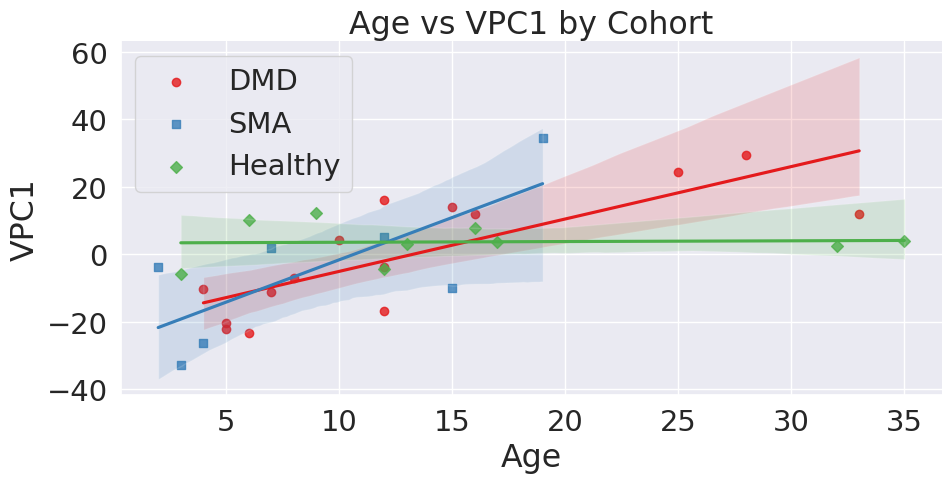

In [31]:
data = pd.read_csv('vpc_curl.csv')

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df and data are defined
df = data.copy()

# Increase the width of the figure
plt.figure(figsize=(12, 6))  # Increased width

# Scatter plot with different markers for each cohort
sns.lmplot(x='Age', y='vpc1', hue='Cohort', data=df, palette='Set1', markers=['o', 's', 'D'], legend=False, height=5, aspect=2)  # Aspect ratio increased

plt.title('Age vs VPC1 by Cohort')
plt.xlabel('Age')
plt.ylabel('VPC1')

# Remove the legend title
plt.legend(title='')

# Save the figure
# plt.savefig('age_vpc1_by_cohort.png', dpi=300, bbox_inches='tight')

## Mixed Effects Regression

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


df_curl = pd.read_csv('vpc_curl.csv')
mixed_effect_df = df_curl[['PID','Age','vpc1','vpc2','Cohort','visits']]

# Define a dictionary to control the sort order
sort_order = {'Healthy': 1, 'DMD': 2, 'SMA': 3}

# Apply sort by transforming 'Cohort' into categorical type with specified order
mixed_effect_df['Cohort'] = pd.Categorical(mixed_effect_df['Cohort'], categories=['Healthy', 'DMD', 'SMA'], ordered=True)

# Sort the DataFrame
mixed_effect_df = mixed_effect_df.sort_values('Cohort')

# Adjust age
# mixed_effect_df['days'] = mixed_effect_df.groupby('PID')['visits'].transform(lambda x: (x - x.min()).dt.days)
# mixed_effect_df['Age'] = mixed_effect_df['Age'] + (mixed_effect_df['days']/365)
mixed_effect_df


# Fit a mixed-effects model
model = smf.mixedlm('vpc1 ~ Age * Cohort', mixed_effect_df, groups=mixed_effect_df['PID'])

# Fit a linear model
result1 = model.fit()

# Display the results
print(result1.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   vpc1     
No. Observations:     31        Method:               REML     
No. Groups:           31        Scale:                63.5987  
Min. group size:      1         Log-Likelihood:       -109.1900
Max. group size:      1         Converged:            Yes      
Mean group size:      1.0                                      
---------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept           3.335    6.330  0.527 0.598  -9.071  15.742
Cohort[T.DMD]     -23.924    6.166 -3.880 0.000 -36.009 -11.840
Cohort[T.SMA]     -30.043    8.583 -3.500 0.000 -46.865 -13.220
Age                 0.022    0.289  0.075 0.940  -0.545   0.589
Age:Cohort[T.DMD]   1.530    0.276  5.553 0.000   0.990   2.070
Age:Cohort[T.SMA]   2.484    0.704  3.531 0.000   1.1

/home/user/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Example data
# data should be your DataFrame with columns: response, age, cohort, and group

# Fit the mixed-effects model
model_vpc1 = smf.mixedlm("vpc1 ~ Age * Cohort", mixed_effect_df, groups=mixed_effect_df["PID"])
result_vpc1 = model_vpc1.fit()

# Extract p-values
p_values_vpc1 = result_vpc1.pvalues
p_values_vpc1.dropna(inplace=True)

# Combine p-values
combined_p_values = p_values_vpc1.tolist()

# Apply Benjamini-Hochberg correction
corrected_p_values = multipletests(combined_p_values, alpha=0.05, method='fdr_bh')[1]

# Create a dictionary to map back to the original p-values with unique keys
corrected_p_dict = {f'vpc1_{k}': v for k, v in zip(p_values_vpc1.index.tolist(), corrected_p_values[:len(p_values_vpc1)])}

corrected_p_dict

/home/user/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


{'vpc1_Intercept': 0.7179008356553439,
 'vpc1_Cohort[T.DMD]': 0.00031289856776333226,
 'vpc1_Cohort[T.SMA]': 0.0006970921961841171,
 'vpc1_Age': 0.9402560661278001,
 'vpc1_Age:Cohort[T.DMD]': 1.682681982933022e-07,
 'vpc1_Age:Cohort[T.SMA]': 0.0006970921961841171}